In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import seaborn as sns

In [19]:
# delta time (timestep)
dt = 0.001
# Number of time steps
ndt = 400
# Length
L = 1
# Number of grids == number of nodes-1
ndx = 4
ndy = 5
m = ndx*ndy
dx = 1
dy = 1
h = 1
# Static rock properties
phi = 0.2
kx = 2
ky = 2
Vb = dx*dy*h
cp = 1e-6
# fluid properties
mu = 1
rho = 62.4
FVF = 1
betha_c = 0.001127
cf = 1e-5
alpha_c = 5.614583

T = betha_c*dy*h*kx/(mu*FVF*dx)

RHS = (Vb*phi*(cf+cp))/(alpha_c*FVF*dt)

In [141]:
RHS*4000

1.5673470318276534

In [22]:
ij_to_m = lambda i, j: (j-1)*ndx+i # convert poisition to m

In [23]:
ijpy_to_m = lambda i, j: (j)*ndx+i+1 # convert pythonic position (index starts from zero) to m

In [24]:
# list of all coordinations (i,j) and m
ijpy_m = []
for j in range(ndy):
    for i in range(ndx):
        ijpy_m.append(( (i, j), ijpy_to_m(i, j)))

In [25]:
# Check whether the block is a boundary grid block
def is_exterior(i, j):
    if i==0 or i==ndx-1 or j==0 or j==ndy-1:
        return True
    else:
        return False

In [26]:
# Check whether the block is inactive
def is_active(i, j):
    if i<0 or i>=ndx or j<0 or j>=ndy:
        return False
    else:
        return True

In [170]:
tolerance = 1e-4
pi = 4000
ndt = 100
all_A = []
pressure_grid = np.ones([ndx, ndy, ndt]) * pi
well_coords = (1,1)
# Create matrix A
A_m = np.zeros([m,m])
betha = np.zeros([m])
for t in range(ndt-1):
    A_m = np.zeros([m,m])
    betha = np.zeros([m])
    for n in range(m):
        i,j = ijpy_m[n][0]
        # term for neighboring blocks pressures
        if is_active(i-1, j):
            A_m[n, ijpy_to_m(i-1, j)-1] = -T

        if is_active(i, j-1):
            A_m[n, ijpy_to_m(i, j-1)-1] = -T

        if is_active(i+1, j):
            A_m[n, ijpy_to_m(i+1, j)-1] = -T

        if is_active(i, j+1):
            A_m[n, ijpy_to_m(i, j+1)-1] = -T
        
        A_m[n, n] = RHS + 4*T
        
        if is_exterior(i, j):
            if i==0:
                A_m[n, n] -= T
            if i==ndx-1:
                A_m[n, n] -= T
            if j==0:
                A_m[n, n] -= T
            if j==ndy-1:
                A_m[n, n] -= T
        betha[n] = RHS*pressure_grid[i, j, t]
    betha[ijpy_to_m(*well_coords)-1] -= 1
    if t==0:
        betha_zero = betha
    p = np.linalg.solve(A_m, betha)
    all_A.append(A_m)
    pressure_grid[:,:,t+1] = p.reshape(ndx, ndy, order='F').copy()

In [ ]:
# for i,j in [(i, j) for i in range(4) for j in range(5)]:
#     if is_exterior(i, j): 
#         plt.plot(pressure_grid[i,j,:], 'o-')
#     else:
#         plt.plot(pressure_grid[i,j,:])


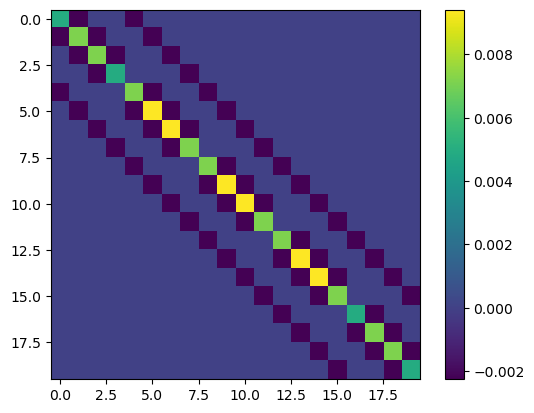

In [172]:
plt.imshow(all_A[0])
plt.colorbar()

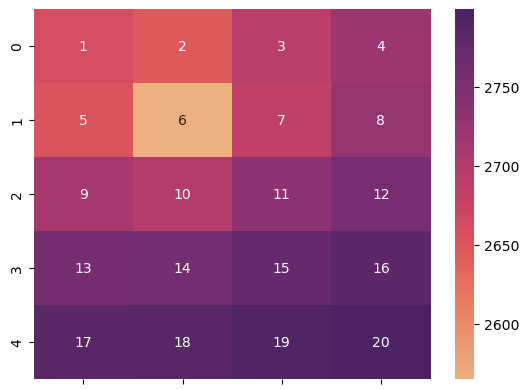

In [173]:
labels = [i+1 for i in range(20)]
labels = np.reshape(labels, (ndy, ndx))
time = 10
# labels = pressure_grid[:,:,time].reshape(ndy, ndx)

ax = sns.heatmap(pressure_grid[:,:,time].swapaxes(0, 1), cmap="flare", cbar=True, annot=labels)
ax.set(xticklabels=[])
plt.show()
